# Fix Messy Table Extraction

Your PDF has tables, but when you try to extract them, you get garbled data, missing rows, or columns that don't line up. Here's how to fix the most common table extraction problems.

## The Problem

PDF tables come in many flavors, and each one breaks in its own special way:

- **No visible borders**: Text that looks like a table but has no lines
- **Merged cells**: Headers that span multiple columns
- **Inconsistent spacing**: Columns that don't line up perfectly
- **Multiple tables**: Several tables crammed onto one page
- **Rotated tables**: Tables turned sideways or upside down
- **Image tables**: Tables that are actually pictures

Simple extraction methods often fail on these cases.

## Quick Fix: Try Layout Detection First

Instead of extracting tables blind, detect them first:

In [1]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")
page = pdf.pages[0]

# Detect table regions using AI
page.analyze_layout(engine='yolo')

# Find and extract detected tables
table_regions = page.find_all('region[type=table]')
for i, table in enumerate(table_regions):
    data = table.extract_table()
    print(f"Table {i+1}: {len(data)} rows")

image 1/1 /var/folders/25/h3prywj14qb0mlkl2s8bxq5m0000gn/T/tmpvfofocb4/temp_layout_image.png: 1024x800 1 title, 3 plain texts, 2 abandons, 1 table, 999.2ms


Speed: 6.1ms preprocess, 999.2ms inference, 9.0ms postprocess per image at shape (1, 3, 1024, 800)


Table 1: 8 rows


## When Basic Detection Fails: Use TATR

For tables without clear borders or with complex structure:

In [2]:
# Use Table Transformer - understands table structure better
page.clear_detected_layout_regions()  # Clear previous attempts
page.analyze_layout(engine='tatr')

# TATR understands rows, columns, and headers
table = page.find('region[type=table][model=tatr]')
rows = page.find_all('region[type=table-row][model=tatr]')
cols = page.find_all('region[type=table-column][model=tatr]')
headers = page.find_all('region[type=table-column-header][model=tatr]')

print(f"Found: {len(rows)} rows, {len(cols)} columns, {len(headers)} headers")

# Extract using the detected structure
data = table.extract_table(method='tatr')

Found: 8 rows, 4 columns, 1 headers


## Manual Table Definition

When detection fails completely, define the table area yourself:

In [3]:
# Visually inspect the page to find table boundaries
page.show()

# Manually define the table region
table_area = page.create_region(
    x0=50,      # Left edge of table
    top=200,    # Top edge of table
    x1=550,     # Right edge of table
    bottom=400  # Bottom edge of table
)

# Highlight to verify
table_area.show(color="blue", label="Table area")

# Extract from the defined area
data = table_area.extract_table()

<aside style="background: #fff8dc; padding: 10px; border-left: 4px solid #f90;">
  <strong>Pro-tip:</strong> Instead of measuring 120&nbsp;px below the header, try an
  <code>until=...</code> anchor—your script survives if the table grows or the scan
  resolution changes.

  ```python
  header = page.find(text="Violations":bold)
  body   = header.below(
      until="text:contains('Total violations')",
      include_endpoint=False
  )
  data = body.extract_table()
  ```

  In most cases that one extra <code>until=</code> makes the difference between a
  brittle coordinate hack and a reusable extractor.
</aside>

## Define Table Boundaries Using Header Labels

Sometimes the easiest trick is to let the **column headers** tell you exactly where the table starts and ends.
Here's a quick, self-contained approach that works great on the violations table inside `01-practice.pdf`:

In [4]:
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")
page = pdf.pages[0]

# Find all header labels
headers = page.find_all(
    'text:contains("Statute|Description|Level|Repeat")',
    regex=True,
)
col_edges = headers.apply(lambda header: header.x0) + [page.width]
print(col_edges)

headers.show(crop=True)

[55.0, 105.0, 455.0, 505.0, 612]


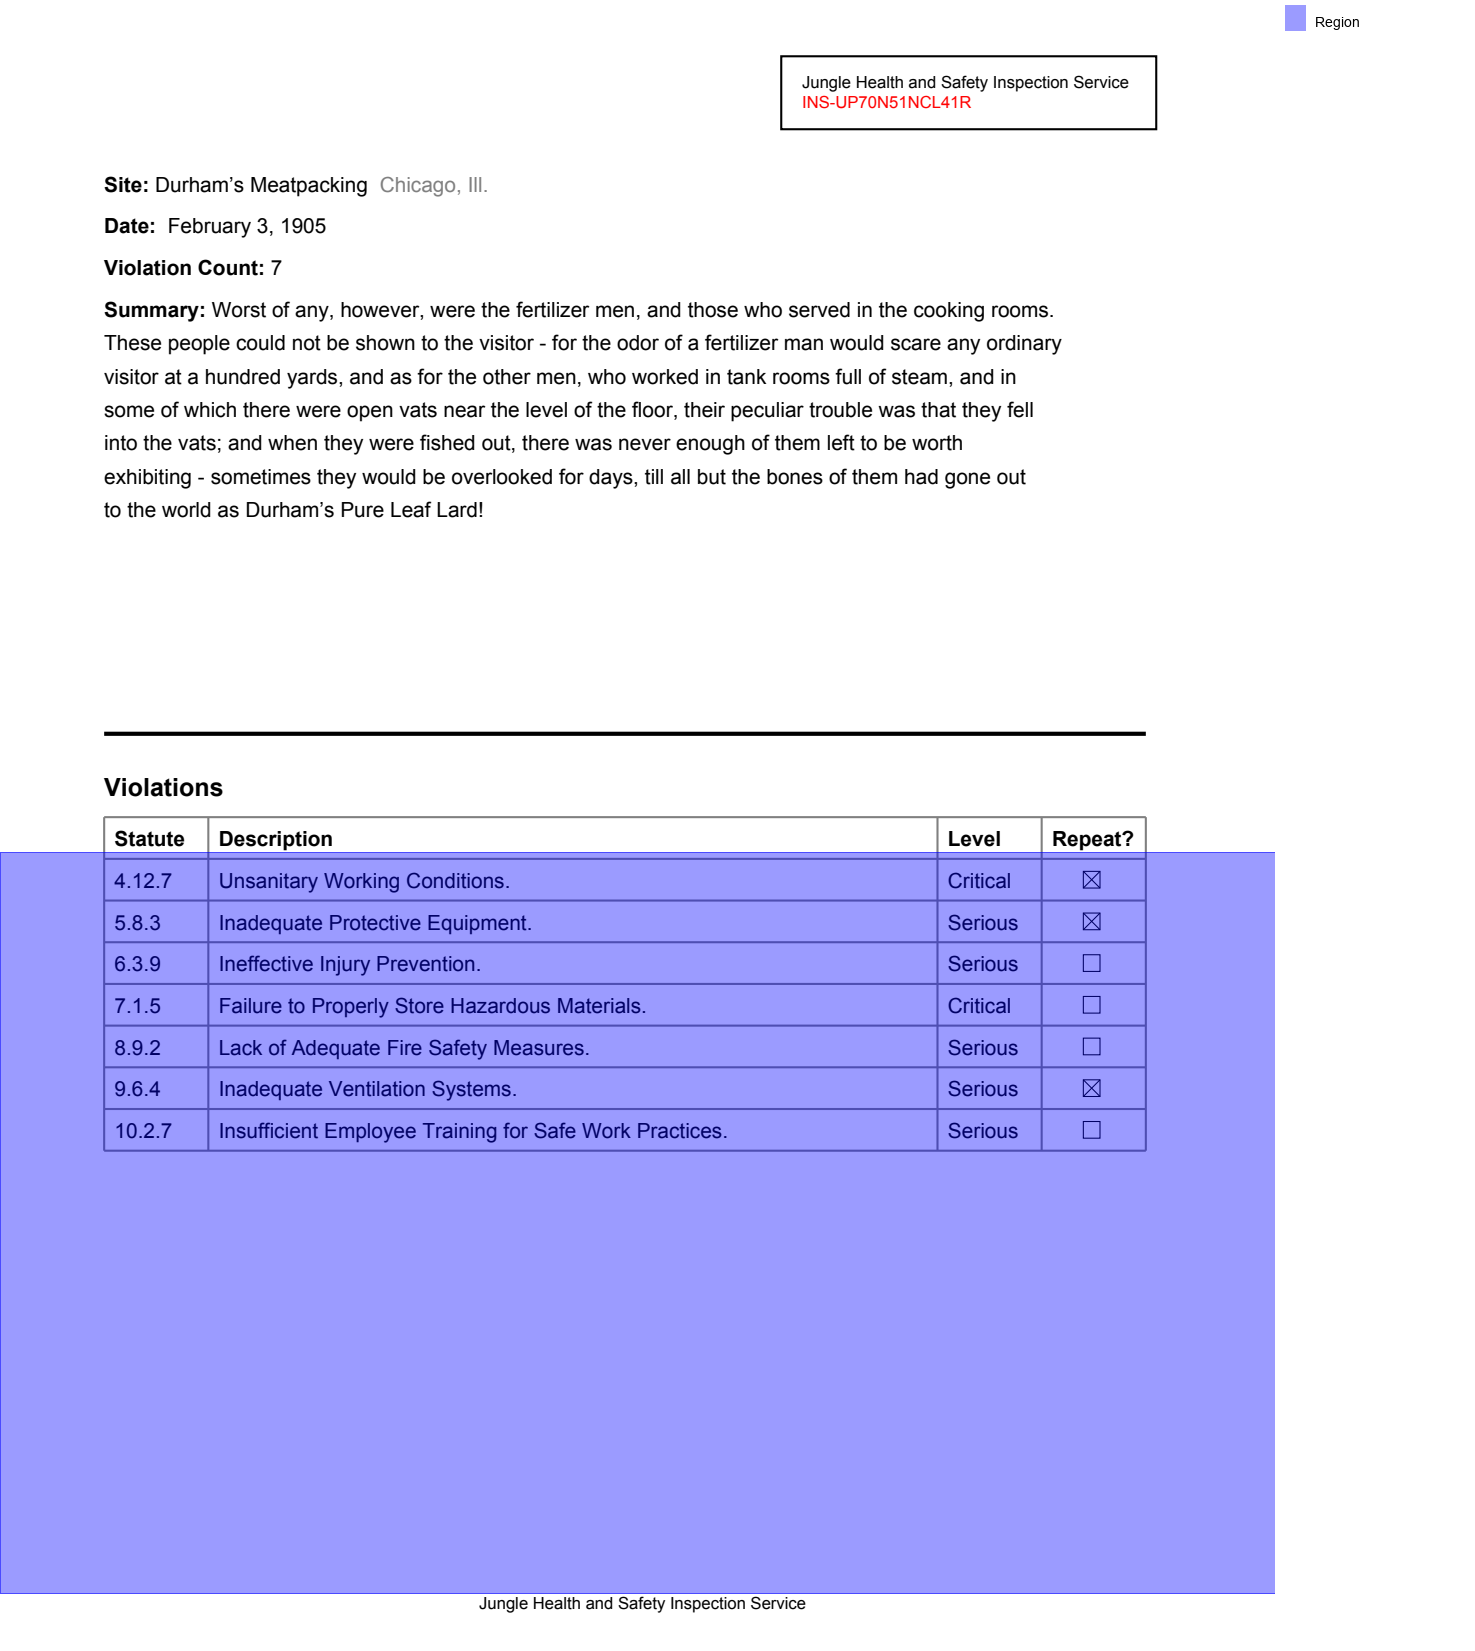

In [5]:
table_area = (
    headers[0]
    .below(
        until="text[size<10]",
        include_endpoint=False
    )
)
table_area.show()

[418.07, 438.07, 458.07, 478.07, 498.07, 518.0699999999999, 538.0699999999999, 548.0699999999999]


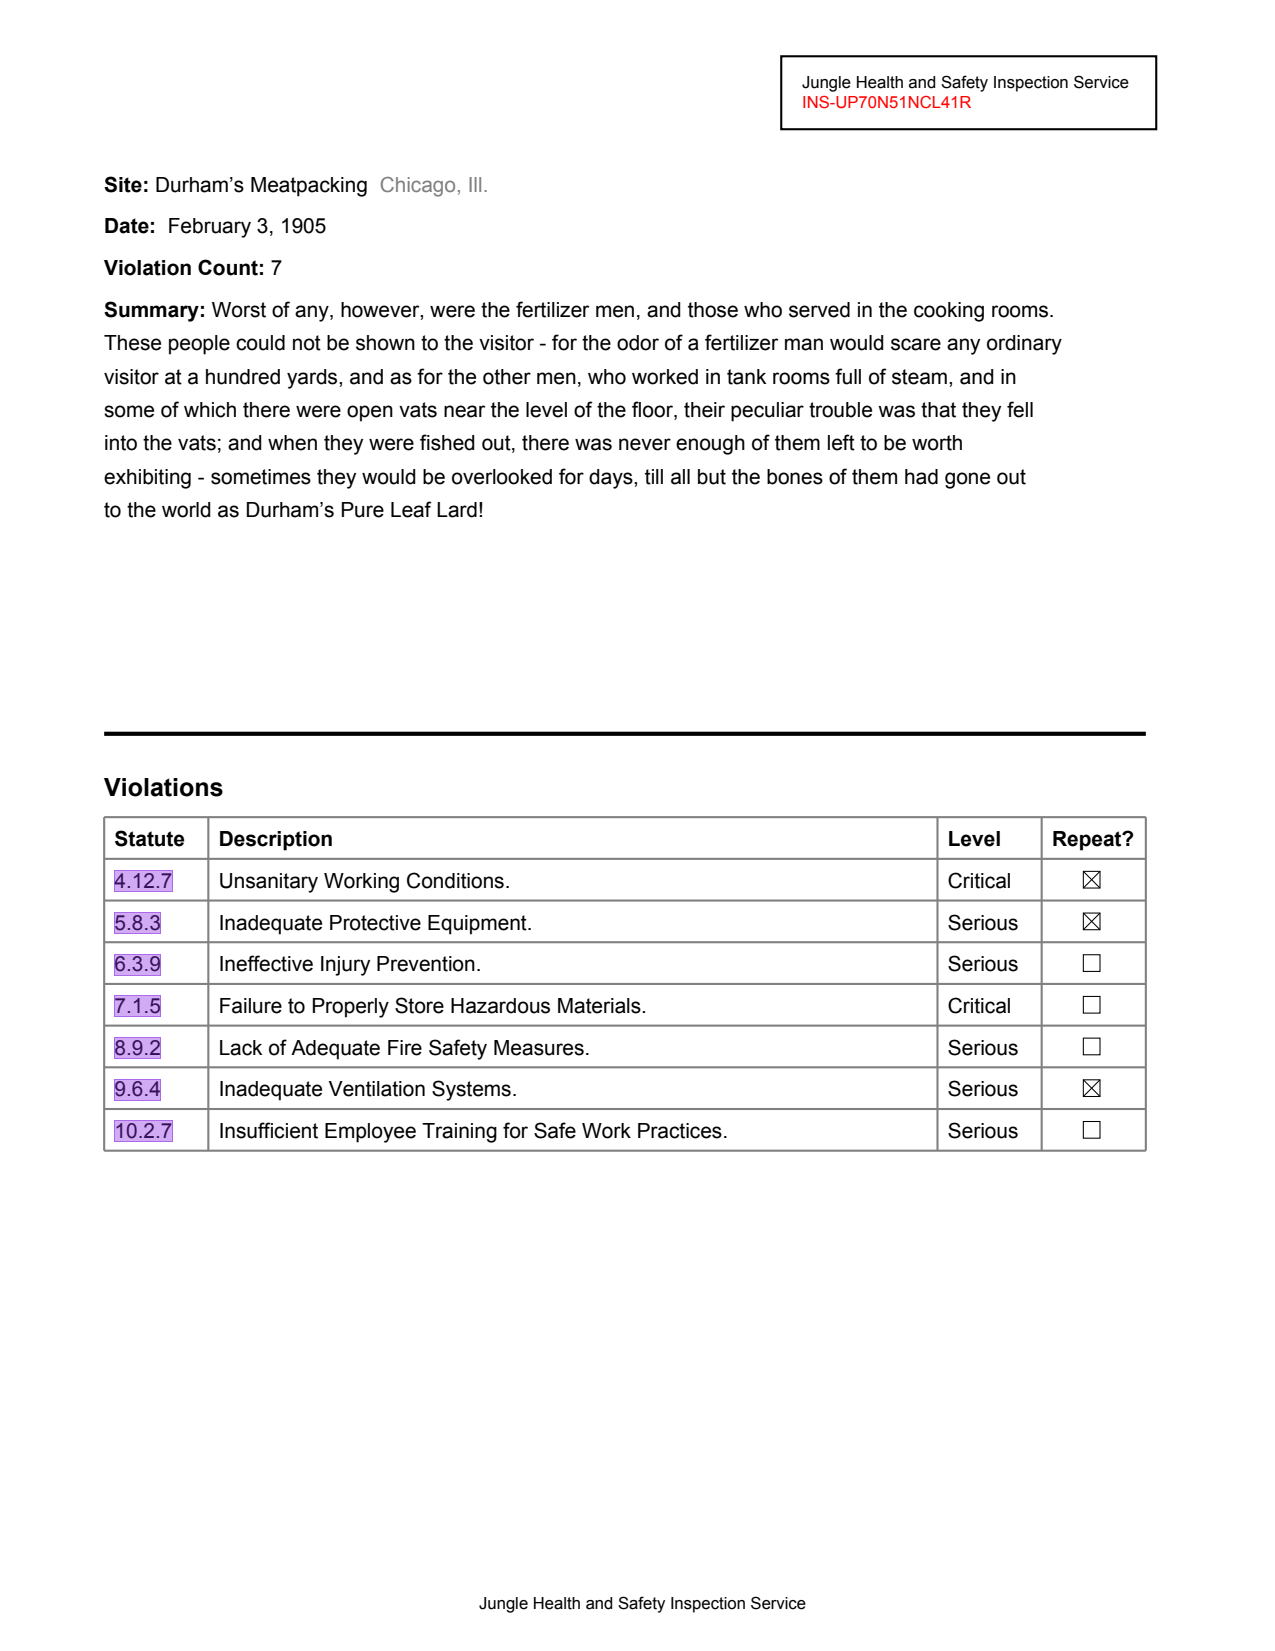

In [6]:
row_items = (
    headers[0]
    .below(width='element')
    .find_all('text')
)

row_borders = row_items.apply(lambda entry: entry.top) + [row_items[-1].bottom]
print(row_borders)
row_items.show()

In [7]:
options = {
    "vertical_strategy": "explicit",
    "horizontal_strategy": "explicit",
    "explicit_vertical_lines": col_edges,
    "explicit_horizontal_lines": row_borders,
}
data = table_area.extract_table('pdfplumber', table_settings=options)
data

TableResult(rows=7…)

## Fix Alignment Issues

When columns don't line up properly:

In [8]:
# Customize pdfplumber settings for better alignment
table_settings = {
    "vertical_strategy": "text",        # Use text alignment instead of lines
    "horizontal_strategy": "lines",     # Still use lines for rows
    "intersection_x_tolerance": 10,     # More forgiving column alignment
    "intersection_y_tolerance": 5,      # More forgiving row alignment
    "edge_min_length": 3,              # Shorter minimum line length
}

data = table_area.extract_table(table_settings=table_settings)

## Handle Multiple Tables on One Page

Separate and extract each table individually:

In [9]:
# Detect all tables
page.analyze_layout(engine='yolo')
tables = page.find_all('region[type=table]')

print(f"Found {len(tables)} tables")

# Extract each table separately
all_data = []
for i, table in enumerate(tables):
    data = table.extract_table()
    all_data.append(data)

# Show all tables together
with page.highlights() as h:
    for i, table in enumerate(tables):
        h.add(table, color="red", label=f"Table {i+1}")
    h.show()

# Save each table separately
import pandas as pd
for i, tbl in enumerate(all_data):
    df = tbl.to_df(header="first")
    df.to_csv(f"table_{i+1}.csv", index=False)

image 1/1 /var/folders/25/h3prywj14qb0mlkl2s8bxq5m0000gn/T/tmpa6halb0m/temp_layout_image.png: 1024x800 1 title, 3 plain texts, 2 abandons, 1 table, 3045.2ms


Speed: 9.9ms preprocess, 3045.2ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 800)


Found 1 tables


## Deal with Rotated Tables

Some PDFs have sideways tables:

In [10]:
# For rotated tables, you might need to work with coordinates differently
# First, see if layout detection picks it up
page.analyze_layout(engine='yolo')
tables = page.find_all('region[type=table]')

# If the table appears rotated in the highlights,
# the extraction might still work normally
for table in tables:
    table.show()  # Check if this looks right
    data = table.extract_table()
    if data and len(data) > 1:  # If we got reasonable data
        print("Table extracted successfully despite rotation")

image 1/1 /var/folders/25/h3prywj14qb0mlkl2s8bxq5m0000gn/T/tmpdaq7jkzh/temp_layout_image.png: 1024x800 1 title, 3 plain texts, 2 abandons, 1 table, 2720.6ms


Speed: 6.2ms preprocess, 2720.6ms inference, 1.0ms postprocess per image at shape (1, 3, 1024, 800)


Table extracted successfully despite rotation


## Extract Tables from Images

When tables are embedded as images:

In [11]:
# Apply OCR first to convert image text to searchable text
page.apply_ocr(engine='easyocr', languages=['en'])

# Now try table detection on the OCR'd content
page.analyze_layout(engine='tatr')
tables = page.find_all('region[type=table]')

# Extract using OCR text
for table in tables:
    data = table.extract_table()

Rendering pages:   0%|          | 0/1 [00:00<?, ?it/s]

Using CPU. Note: This module is much faster with a GPU.


/Users/soma/Development/natural-pdf/.nox/docs/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## Debug Table Extraction Step by Step

When nothing works, debug systematically:

In [12]:
# Step 1: See what elements exist in the table area
table_area = page.create_region(50, 200, 550, 400)
elements = table_area.find_all('text')

print(f"Found {len(elements)} text elements in table area")

# Step 2: See the actual text content
text_content = table_area.extract_text(layout=True)
print("Raw text content:")
print(text_content)

# Step 3: Check for lines that might define the table
lines = table_area.find_all('line')
print(f"Found {len(lines)} lines in table area")

# Step 4: Visualize everything
with page.highlights() as h:
    h.add(elements, color="blue", label="Text")
    h.add(lines, color="red", label="Lines")
    h.show()

Found 9 text elements in table area
Raw text content:
some of which there were open vats near the level of the floor, their peculiar trouble was that they fellsome of which there were open vats near the level of the floor, their peculiar trouble was that they fell
into the vats; and wheninto the vats; and whenthey they were fished out; there was never enough of them left to be worthwere fished out, there was never enough of them left to be worth
exhibitingexhibiting - sometimes they would be overlooked forsometimes they would be overlooked fordays, days, till all but the bones of them had gone outtill all but the bones of them had gone out
to the world as Durham's Pure Leaf Lardlto the world as Durham’s Pure Leaf Lard!
ViolationsViolations                                                 
StatuteStatute DescriptionDescription            LevelLevel Repeat?Repeat?
                                                                     
                                                        

## Troubleshooting Checklist

**No tables detected?**
- Try different engines: `yolo`, `tatr`, `surya`
- Apply OCR first if it's a scanned document
- Manually define the table area

**Columns misaligned?**
- Adjust `intersection_x_tolerance` in table settings
- Try `vertical_strategy="text"` instead of `"lines"`
- Check if there are actual lines vs. just text alignment

**Missing rows?**
- Increase `intersection_y_tolerance`
- Try `horizontal_strategy="text"`
- Look for merged cells that might be confusing the detector

**Garbled data?**
- Extract manually row by row
- Check OCR quality if text looks wrong
- Verify the table region boundaries

**Multiple tables mixed together?**
- Use layout detection to separate them first
- Define manual regions for each table
- Process tables in reading order

## Auto-ignore headers & footers with exclusions

Before you even think about column alignment, make sure **repeated page furniture**
(running headers, footers, page numbers) is out of the way.  Two lines of code
often fix "shifted" columns:

In [13]:
from natural_pdf import PDF

pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")

# Drop top 50 pt (header) and bottom 40 pt (footer) on *every* page
pdf.add_exclusion(lambda p: p.create_region(0, 0, p.width, 50))
pdf.add_exclusion(lambda p: p.create_region(0, p.height-40, p.width, p.height))

pdf.pages[0].extract_table().df

,Statute,Description,Level,Repeat?
0,4.12.7,Unsanitary Working Conditions.,Critical,
1,5.8.3,Inadequate Protective Equipment.,Serious,
2,6.3.9,Ineffective Injury Prevention.,Serious,
3,7.1.5,Failure to Properly Store Hazardous Materials.,Critical,
4,8.9.2,Lack of Adequate Fire Safety Measures.,Serious,
5,9.6.4,Inadequate Ventilation Systems.,Serious,
6,10.2.7,Insufficient Employee Training for Safe Work P...,Serious,


# rows list-of-lists; wrap in TableResult for convenience
rows = (
    pdf.pages
       .apply(lambda p: p.analyze_layout('tatr') or p)
       .apply(lambda p: p.find('table').extract_table())
       .apply(lambda t: t[1:])     # skip header repetition
       .flatten()
)

from natural_pdf.tables import TableResult
df = TableResult(rows).to_df(header="first")
print(df.head())